In [1]:
import cv2
import os
import random
import shutil

import torch
from utils.general import non_max_suppression, scale_boxes
from utils.torch_utils import select_device
from models.experimental import attempt_load


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Video Clips

In [ ]:
video_path = "/content/drive/MyDrive/task/footfall/sample.mp4"

# Extract Frame per 0.1 second

In [ ]:
output_dir = '/content/drive/MyDrive/task/footfall/extracted_frames3'
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
time_lapse = 0.1

count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if count % int(frame_rate * time_lapse) == 0:  # extract one frame per second
        frame_filename = os.path.join(output_dir, f'frame_{count}.jpg')
        cv2.imwrite(frame_filename, frame)
    count += 1

cap.release()
print("Frames extracted.")

Frames extracted.


# Create Empty Annotation for no name tag image

In [ ]:
def create_empty_annotations(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    for image_file in image_files:
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(image_dir, label_file)
        if not os.path.exists(label_path):
            open(label_path, 'w').close()  # Create an empty file

image_dir = "/content/drive/MyDrive/task/footfall/extracted_frames3"
create_empty_annotations(image_dir)

# Data Augmentation


In [ ]:

# Define augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Paths
input_images_dir = '/content/drive/MyDrive/task/footfall/extracted_frames3'
output_images_dir = '/content/drive/MyDrive/task/footfall/augmented_images'
output_labels_dir = '/content/drive/MyDrive/task/footfall/augmented_labels'

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))

# Process each image file
for img_name in os.listdir(input_images_dir):
    if not is_image_file(img_name):
        continue

    img_path = os.path.join(input_images_dir, img_name)
    label_path = os.path.join(input_images_dir, img_name.replace('.jpg', '.txt'))  # Assuming .txt annotation files

    # Load image using OpenCV
    image = cv2.imread(img_path)
    if image is None:
        print(f"Skipping unreadable image file: {img_path}")
        continue

    height, width, _ = image.shape

    # Load bounding boxes
    boxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_labels.append(int(parts[0]))
                boxes.append([float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])

    # Apply augmentations
    for i in range(5):  # Create 5 augmented versions of each image
        augmented = transform(image=image, bboxes=boxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_boxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Save augmented image
        aug_img_name = f"{img_name.split('.')[0]}_aug_{i}.jpg"
        cv2.imwrite(os.path.join(output_images_dir, aug_img_name), aug_image)

        # Save augmented bounding boxes
        aug_label_name = f"{img_name.split('.')[0]}_aug_{i}.txt"
        with open(os.path.join(output_labels_dir, aug_label_name), 'w') as f:
            for bbox, label in zip(aug_boxes, aug_class_labels):
                bbox = [str(x) for x in bbox]
                label = str(label)
                f.write(' '.join([label] + bbox) + '\n')

print("Augmentation completed successfully.")


Augmentation completed successfully.


# Data Partition

In [ ]:

# Paths
images_dir = '/content/drive/MyDrive/task/footfall/augmented_images'
labels_dir = '/content/drive/MyDrive/task/footfall/augmented_labels'
train_images_dir = '/content/drive/MyDrive/task/footfall/train_aug_images'
train_labels_dir = '/content/drive/MyDrive/task/footfall/train_aug_label'
val_images_dir = '/content/drive/MyDrive/task/footfall/val_aug_images'
val_labels_dir = '/content/drive/MyDrive/task/footfall/val_aug_label'

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# List of all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Shuffle and split the dataset
random.shuffle(image_files)
split_index = int(len(image_files) * 0.8)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move files to training and validation directories
for file in train_files:
    shutil.move(os.path.join(images_dir, file), os.path.join(train_images_dir, file))
    shutil.move(os.path.join(labels_dir, file.replace('.jpg', '.txt')), os.path.join(train_labels_dir, file.replace('.jpg', '.txt')))

for file in val_files:
    shutil.move(os.path.join(images_dir, file), os.path.join(val_images_dir, file))
    shutil.move(os.path.join(labels_dir, file.replace('.jpg', '.txt')), os.path.join(val_labels_dir, file.replace('.jpg', '.txt')))

print("Dataset split into training and validation sets.")


Dataset split into training and validation sets.


In [ ]:


# Define paths
train_images_dir = '/content/drive/MyDrive/task/footfall/train_aug_images'
train_labels_dir = '/content/drive/MyDrive/task/footfall/train_aug_label'
val_images_dir = '/content/drive/MyDrive/task/footfall/val_aug_images'
val_labels_dir = '/content/drive/MyDrive/task/footfall/val_aug_label'

combined_train_dir = '/content/drive/MyDrive/task/footfall/train_combined'
combined_val_dir = '/content/drive/MyDrive/task/footfall/val_combined'

# Create combined directories if they don't exist
os.makedirs(combined_train_dir, exist_ok=True)
os.makedirs(combined_val_dir, exist_ok=True)

# Function to copy files
def copy_files(images_dir, labels_dir, combined_dir):
    for file_name in os.listdir(images_dir):
        img_path = os.path.join(images_dir, file_name)
        label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))
        if os.path.isfile(img_path):
            shutil.copy(img_path, os.path.join(combined_dir, file_name))
        if os.path.isfile(label_path):
            shutil.copy(label_path, os.path.join(combined_dir, os.path.basename(label_path)))

# Copy training data
copy_files(train_images_dir, train_labels_dir, combined_train_dir)

# Copy validation data
copy_files(val_images_dir, val_labels_dir, combined_val_dir)

print("Files copied successfully.")


Files copied successfully.


# Install Yolo Model

In [3]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [4]:
!pip install -r requirements.txt


# Model Training

In [21]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/drive/MyDrive/task/yolotml.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt


2024-07-22 05:27:04.461476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 05:27:04.461531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 05:27:04.462841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/content/drive/MyDrive/task/yolotml.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, d

In [23]:
%cd /content/yolov5
!ls /content/yolov5


/content/yolov5
benchmarks.py	 data	     LICENSE	     README.md	       segment	       val.py
CITATION.cff	 detect.py   models	     README.zh-CN.md   train.py        yolov5s.pt
classify	 export.py   __pycache__     requirements.txt  tutorial.ipynb
CONTRIBUTING.md  hubconf.py  pyproject.toml  runs	       utils


# Display Frame list that detected name tag

In [29]:




# Define the device if have GPU use GPu otherwise use CPU
device = select_device('')

# file path for the trained model
model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# Load the YOLOv5 model
model = attempt_load(model_path, device=device)

# Define the video input and output
input_video_path = '/content/drive/MyDrive/task/sample.mp4'
output_video_path = '/content/drive/MyDrive/task/output_video.mp4'

# Open the video file for reading
cap = cv2.VideoCapture(input_video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

frame_count = 0

# loop the video frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:  #break the loop if no frame is read
        break

    # Resize frame to 640x640
    frame_resized = cv2.resize(frame, (640, 640))

    # Convert frame to tensor
    img = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img).to(device)
    img = img.permute(2, 0, 1).float()
    img = img.unsqueeze(0)
    img /= 255.0

    # Detect name tag
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, 0.25, 0.45, agnostic=False)

    # Process detections
    detected = False
    for det in pred:
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], frame_resized.shape).round()
            for *xyxy, conf, cls in reversed(det):
                label = f'{model.names[int(cls)]} {conf:.2f}'
                if model.names[int(cls)] == 'name tag':
                    cv2.rectangle(frame_resized, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                    cv2.putText(frame_resized, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    detected = True

    if detected:
        print(f"Name tag detected in frame {frame_count}.")
    else:
        print(f"No name tag detected in frame {frame_count}.")

    # Write the frame to the output video
    out.write(frame_resized)
    frame_count += 1

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


No name tag detected in frame 0.
No name tag detected in frame 1.
No name tag detected in frame 2.
No name tag detected in frame 3.
No name tag detected in frame 4.
No name tag detected in frame 5.
No name tag detected in frame 6.
No name tag detected in frame 7.
No name tag detected in frame 8.
No name tag detected in frame 9.
No name tag detected in frame 10.
No name tag detected in frame 11.
No name tag detected in frame 12.
No name tag detected in frame 13.
No name tag detected in frame 14.
No name tag detected in frame 15.
No name tag detected in frame 16.
No name tag detected in frame 17.
No name tag detected in frame 18.
No name tag detected in frame 19.
No name tag detected in frame 20.
No name tag detected in frame 21.
No name tag detected in frame 22.
No name tag detected in frame 23.
No name tag detected in frame 24.
No name tag detected in frame 25.
No name tag detected in frame 26.
No name tag detected in frame 27.
No name tag detected in frame 28.
No name tag detected in 

# Display image

YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


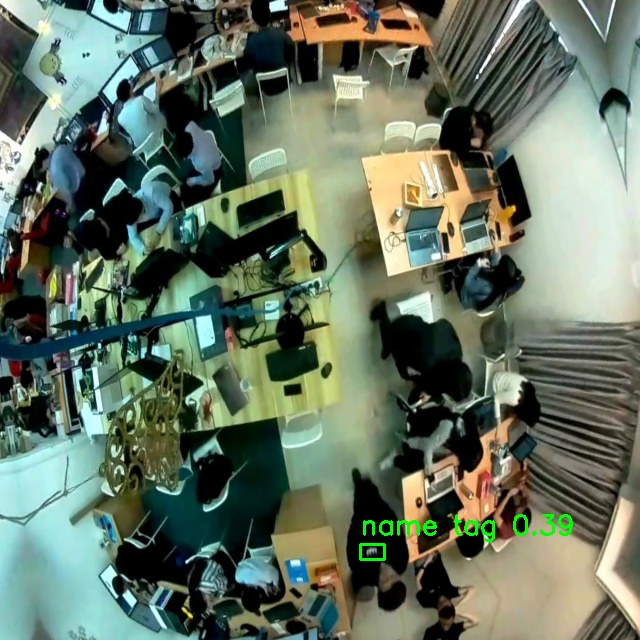

In [33]:

# Define the device
device = select_device('')

# Correct file path for the trained weights
model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# Load the YOLOv5 model
model = attempt_load(model_path, device=device)

# Define the image input and output paths
input_image_path = '/content/drive/MyDrive/task/train_combined/frame__aug_1.jpg'
output_image_path = '/content/drive/MyDrive/task/output1.jpg'

# Read the image
img = cv2.imread(input_image_path)

# Resize image to 640x640
img_resized = cv2.resize(img, (640, 640))

# Convert image to tensor
img_tensor = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img_tensor).to(device)
img_tensor = img_tensor.permute(2, 0, 1).float()
img_tensor = img_tensor.unsqueeze(0)
img_tensor /= 255.0

pred = model(img_tensor, augment=False)[0]
pred = non_max_suppression(pred, 0.25, 0.45, agnostic=False)

# Process detections
for det in pred:
    if len(det):
        det[:, :4] = scale_boxes(img_tensor.shape[2:], det[:, :4], img_resized.shape).round()
        for *xyxy, conf, cls in reversed(det):
            label = f'{model.names[int(cls)]} {conf:.2f}'
            if model.names[int(cls)] == 'name tag':
                cv2.rectangle(img_resized, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                cv2.putText(img_resized, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Save the output image
cv2.imwrite(output_image_path, img_resized)

# Display the output image
from IPython.display import Image, display
display(Image(filename=output_image_path))


# Display Video

In [40]:


# Define the device
device = select_device('')

# Correct file path for the trained weights
model_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# Load the YOLOv5 model
model = attempt_load(model_path, device=device)

# Define the video input and output paths
input_video_path = '/content/drive/MyDrive/task/sample.mp4'
output_video_path = '/content/drive/MyDrive/task/detected_video.mp4'

# Open the video file
cap = cv2.VideoCapture(input_video_path)
# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open input video.")
    exit()

# Get the width and height of the video frames
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to 640x640
    frame_resized = cv2.resize(frame, (640, 640))

    # Convert frame to tensor
    img = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img).to(device)
    img = img.permute(2, 0, 1).float()
    img = img.unsqueeze(0)
    img /= 255.0

    # Perform inference
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, 0.25, 0.45, agnostic=False)

    # Process detections
    for det in pred:
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], frame_resized.shape).round()
            for *xyxy, conf, cls in reversed(det):
                label = f'{model.names[int(cls)]} {conf:.2f}'
                if model.names[int(cls)] == 'name tag':
                    cv2.rectangle(frame_resized, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                    cv2.putText(frame_resized, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Resize the frame back to original size for saving
    frame_original_size = cv2.resize(frame_resized, (frame_width, frame_height))

    # Write the frame to the output video
    out.write(frame_original_size)
    frame_count += 1

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Output video saved at {output_video_path}")


YOLOv5 🚀 v7.0-345-g8003649c Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


Output video saved at /content/drive/MyDrive/task/detected_video.mp4
